In [1]:
%pylab inline

/home/gjones/miniconda2/envs/readout/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [2]:
from kid_readout import *
from kid_readout.roach import attenuator

In [3]:
ri = roach.r2heterodyne.Roach2Heterodyne(roachip='r2kid',attenuator=attenuator.Attenuator(),adc_valon='/dev/ttyUSB4',lo_valon='/dev/ttyUSB3',initialize=False)

In [12]:
ri.set_dac_atten(0)

In [58]:
low_group = np.array([ 1119.07673511,  1126.0153982 ,  1133.70131753,  1135.31245427,
        1143.21576741,  1148.0169738 ,  1159.41786884,  1160.26943775, 1162.33,
        1176.56747357,  1177.70848608,  1181.33728799,  1186.05472363,
        1190.29108718,  1193.62180971,  1203.87755917,  1205.8392229 ,
        1207.88046178,  1220.05286255,  1221.41371349,  1235.26613658, 1243.71])

to_add = 32 - len(low_group)
low_group = np.hstack((low_group,np.arange(to_add)+low_group.max()+2.))
low_group_lo = 1110.0

high_group = np.array([1576.67969747,  1599.40494104,  1605.60503541,
        1609.7742154 ,
        1623.02,
                       1628.5448411 ,  1648.17537644,  1649.22774551,
        1650.36575278,  1662.37845567,  1664.1706628 ,  1681.28526333,
        1682.17350834,  1684.44471064,  1702.0820426 ,  1706.79635917,
        1714.66047719,
                       1720.7, 1724.39938475,  1752.05587464,  1767.515093])

to_add = 32 - len(high_group)
high_group = np.hstack((high_group,np.arange(to_add)+high_group.max()+2.))
high_group_lo = 1570.0

nsamp = 2**18
step = 1
nstep = 16
offset_bins = np.arange(-(nstep + 1), (nstep + 1)) * step
offsets = offset_bins * 512.0 / nsamp

In [6]:
ri.set_lo(low_group_lo)

In [19]:
offsets

array([-0.3828125, -0.375    , -0.3671875, -0.359375 , -0.3515625,
       -0.34375  , -0.3359375, -0.328125 , -0.3203125, -0.3125   ,
       -0.3046875, -0.296875 , -0.2890625, -0.28125  , -0.2734375,
       -0.265625 , -0.2578125, -0.25     , -0.2421875, -0.234375 ,
       -0.2265625, -0.21875  , -0.2109375, -0.203125 , -0.1953125,
       -0.1875   , -0.1796875, -0.171875 , -0.1640625, -0.15625  ,
       -0.1484375, -0.140625 , -0.1328125, -0.125    , -0.1171875,
       -0.109375 , -0.1015625, -0.09375  , -0.0859375, -0.078125 ,
       -0.0703125, -0.0625   , -0.0546875, -0.046875 , -0.0390625,
       -0.03125  , -0.0234375, -0.015625 , -0.0078125,  0.       ,
        0.0078125,  0.015625 ,  0.0234375,  0.03125  ,  0.0390625,
        0.046875 ,  0.0546875,  0.0625   ,  0.0703125,  0.078125 ,
        0.0859375,  0.09375  ,  0.1015625,  0.109375 ,  0.1171875,
        0.125    ,  0.1328125,  0.140625 ,  0.1484375,  0.15625  ,
        0.1640625,  0.171875 ,  0.1796875,  0.1875   ,  0.1953

In [7]:
ri.blocks_per_second

122.0703125

In [57]:
(512e6/2**14.)/256.

122.0703125

In [46]:
122*(256/32.)

976.0

In [56]:
3906*256/32.

31248.0

In [47]:
np.add.outer(offsets,low_group).shape

(98, 32)

In [63]:
swa = acquire.run_sweep(ri,np.add.outer(offsets,low_group),nsamp,length_seconds=2)

got bad packet
got bad packet


In [64]:
swp = swa.sweep(2)

In [65]:
swp.streams[0].s21_raw.shape

(2048,)

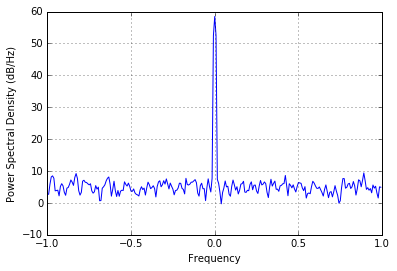

In [66]:
_=psd(swp.streams[0].s21_raw)

In [52]:
ri.boffile

'r2iq2xpfb14mcr12gb_2016_Feb_20_0948.bof'

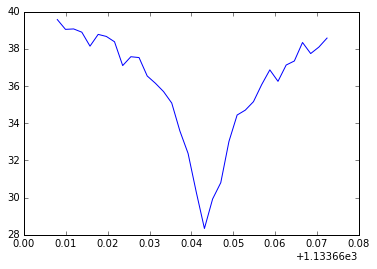

In [61]:
plot(swp.frequency_MHz_stack,20*np.log10(np.abs(swp.s21_points)))

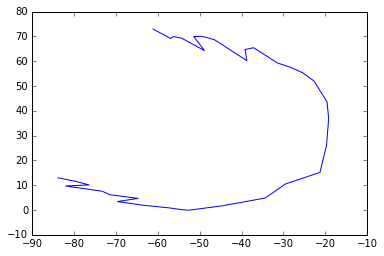

In [62]:
plot_ri(swp.s21_points)

In [30]:
ri.set_dac_atten(30)

In [42]:
x,y = ri.get_raw_adc()

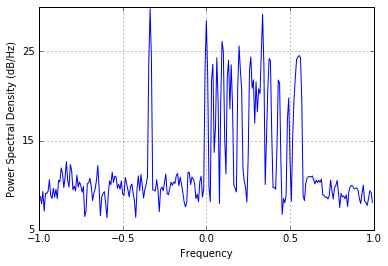

In [43]:
_=psd(x+1j*y)

In [44]:
x.std()

6.5855899913690354

In [35]:
x.ptp()

1363.0

In [30]:
(20/2.5)**2

64.0